### Imports

In [7]:
import os, cv2, csv
from sympy import *
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ctypes import resize
from matplotlib.patches import Arc as arc
from scipy import optimize
from itertools import compress
%matplotlib inline


### Load dummy images from previous non-compucentric rotation

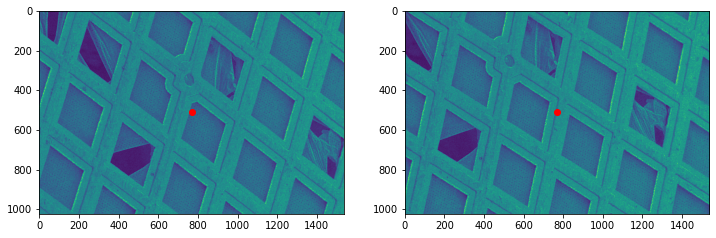

In [8]:
folder = Path(r'\\samba-pool-plitzko2.biochem.mpg.de\pool-plitzko2\Johann\03-Data\06-FIB-SEM\220922_MeteorAutomation\220926_230456_1.0deg_360_300um_MovementTestAligned')
#folder = Path(r'\\samba-pool-plitzko2.biochem.mpg.de\pool-plitzko2\Johann\03-Data\06-FIB-SEM\220926_SampleDataRotation\final\220926_140948_1.0deg_360_MovementTestAligned')

#plot_position_data(file)
files = []
for file in os.listdir(folder):
    if file.endswith(".jpg"):# and file.startswith('raw'):
        files.append(file)
        #print(file)

file_reference = [f for f in files if '_1.0' in f]
img_reference = cv2.imread(os.path.join(folder,file_reference[0]),cv2.IMREAD_GRAYSCALE)
angle = 6.0
file_alignment = [f for f in files if '_'+ str(angle) in f]
img_alignment = cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE)
#### Test if a cropped alignment image works better. (Spoiler: it doesn't) ####
#c = 0.0
#crop = []
#crop.append(int(np.round(img_alignment.shape[0]*c)))
#crop.append(int(np.round(img_alignment.shape[1]*c)))
#print(crop)
#print(crop[1],img_alignment.shape[1]-crop[1],crop[0],img_alignment.shape[0]-crop[0])
#img_alignment = img_alignment[crop[0]:img_alignment.shape[0]-crop[0],crop[1]:img_alignment.shape[1]-crop[1]].copy()

fig,(ax1_0,ax2_0) = plt.subplots(1,2,figsize=(12,9))
ax1_0.imshow(img_reference)
ax1_0.plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
ax2_0.imshow(img_alignment)
ax2_0.plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')

### Feature matching functions

In [9]:
def detect_and_plot(image, axes,N_FEATURES=2000):
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp, des = orb.detectAndCompute(image, None)
    kp_img = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=0)
    axes.imshow(kp_img)

def matchFeatures(img_to_align: np.ndarray, img_reference: np.ndarray, MIN_MATCHES=50, N_FEATURES=5000,DIST_THRES=0.7,VERBOSE=False, DISPLAY_MATCHES=False) -> np.ndarray | None:
    '''
    Returns: Corrected_img, mat
    Corrected_img: The warped image to the detected position of the reference.
    Mat: The perspective transformation matrix. The top left 2x2 sub-matrix is a rotation matrix. The right colum is the
    translation in homogeneous coordinates and the bottom indices 2,0 and 2,1 contain the projection vector.

    This function uses the OpenCV implementation of the unpatented Oriented FAST and Rotated BRIEF algorithms
    (ORB, Rublee,2011) together with a nearest neighbor matcher(Fast Library for Approximate Nearest Neighbors (FLANN)).
    ORB uses the on the well-known Features from Accellerated Segmentation Test (FAST) keypoint detector and 
    the Binary Robust Independent Elementary Features (BRIEF) descriptor. Due to the patch orientation, the BRIEF
    algorithm looses its invariance to rotation and hence performed best out of tested SURF and SIRT algorithms.  
    This function finds the homography from two given images (img_to_alig is aligned to the img_reference). 
    MIN_MATCHES: Minimal number of "good" matching features in both images
    N_FEATURES: Initally detected features per image
    DIST_THRES: "Goodness" parameter (the lower the better, can be increase if matcher is to critical)
    VERBOSE: Prints matching results
    DISPLAY_MATCHES: Creates a figure with connected features from both images.

    '''
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp1, des1 = orb.detectAndCompute(img_to_align, None)
    kp2, des2 = orb.detectAndCompute(img_reference, None)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # As per Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < DIST_THRES * n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCHES:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        mat, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 10.0)
        corrected_img = cv2.warpPerspective(img_to_align, mat, (img_reference.shape[1], img_reference.shape[0]))
        if DISPLAY_MATCHES:            
            match_img = cv2.drawMatches(img_to_align, kp1, img_reference, kp2, good_matches[:50], None)
            f, ax = plt.subplots()
            ax.imshow(match_img)
            plt.show()
        if VERBOSE:
            print('Matching successful')
        return corrected_img, mat.copy()
    elif DIST_THRES < 0.95: 
        if VERBOSE:       
            print('Matching failed, trying to enlarge threshold for good matches.({})'.format(DIST_THRES+0.1))
        corrected_img, mat = matchFeatures(img_to_align, img_reference, DIST_THRES=DIST_THRES+0.1, DISPLAY_MATCHES=True)
        return corrected_img, mat.copy()
    else:
        if VERBOSE:
            print('Matching failed')
        return None, None

def get_pixel_size(img : np.ndarray,HFW : float)-> float:
    '''
    Calculates the pixel size from an representative image and the given horizontal field width (HFW)
    '''
    return HFW/img.shape[1]

def get_params_from_transformation_matrix(m: np.ndarray, pixel_size=0.0, PRINT=False) -> dict|None:
    '''
    Deconstructs a given 3x3 perspective transform matrix into the relevant parameters
    Returns: Dict with the parameters:
    't': 2x1 list, Translation in pixel units
    't_meter':2x1 list, Translation in meters (calibrated with given pixel_size parameter)
    'phi': 3x1 list, Calculated, scaled angles from the two rows of the rotation matrix in degrees. Third
    index is the mean rotation angle.
    's': 2x1 Scaling factors in x and y directions
    
    '''
    if np.abs(m[2,0]) > 1e-3 or np.abs(m[2,1]) > 1e-3 :
        print("This is no valid transformation matrix, the projection component is too large.")
        return None
    else:
        a,b,c,d = m[0,0] , m[0,1], m[1,0], m[1,1]
        result = {}
        result['t'] = [m[0,2], m[1,2]]
        sx, sy = np.sqrt(a ** 2 + c ** 2) , np.sqrt(b ** 2 + d ** 2)
        result['s']  = [sx, sy]
        phi1,phi2 = np.rad2deg(np.arctan((c/sx)/(d/sy))), np.rad2deg(np.arctan((-b/sy)/(a/sx)))
        result['phi']  = [phi1,phi2, np.mean([phi1,phi2])]
        result['t_meter'] =[ t * pixel_size for t in result['t']]   

        if PRINT:                        
            print("---Image Transformation---")
            print("{}\n".format(m))
            if pixel_size > 0.0:         
                print("Translation (x,y) / mm: {:.2f}, {:.2f}".format(m[0,2]*1e3*pixel_size,m[1,2]*1e3*pixel_size))
            print("Translation (x,y) / px: {}, {}".format(m[0,2],m[1,2]))
            print("Scaling (x,y): {}, {}".format(result['s'][0], result['s'][1]))
            print("Rotation Angle (x,y, mean): {}, {}, {}".format(phi1,phi2 ,round(result['phi'][2],2)))
        return result        

def fit_ellipse(x, y):
    """
    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].
    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.
    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

def cart_to_pol(coeffs):
    """
    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.
    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi

def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

def calculate_center_lsq(x: list, y: list, VERBOSE= False) -> dict:
    '''
    A simple LSQ fitting of the circle equation resp. the radius and center coordinates from all available points.
    Returns: Dict:
    'x_c','y_c': Center positions
    'r': Circle radius
    'residuum': Remaining error (Sum of squared error)
    '''
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)

    if VERBOSE:
        print("Center / mm: {},{}".format(xc_2*1e3,yc_2*1e3))
        print("Radius / mm: {}".format(R_2*1e3))
        print("Residuum: {}".format(residu_2))

    return {'xc': xc_2, 'yc': yc_2, 'r': R_2, 'residuum': residu_2}

# Feature matching loop of given rotation images

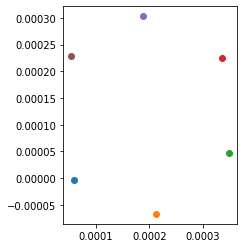

In [10]:
rot_center, params = [],[]
# Caveat: Takes approx. 2s per matching
for ang in np.arange(11.0,359.0,58.0):
    file_alignment = [f for f in files if '_'+ str(ang) in f]
    img_alignment = cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE)    
    for i in range(1):    
        corrected_img, transformationMatrix = [], []
        corrected_img, transformationMatrix = matchFeatures(img_reference=img_reference, img_to_align= img_alignment, DISPLAY_MATCHES=False)
    params.append(get_params_from_transformation_matrix(transformationMatrix,pixel_size=get_pixel_size(img_reference,300e-6), PRINT=False))
    rot_center.append(params[-1]['phi'][2])
    #print(ang)

fig, ax = plt.subplots()
x,y = [],[]
for _ in range(len(params)):
    x.append(params[_]['t_meter'][0])   
    y.append(params[_]['t_meter'][1])
    ax.plot(params[_]['t_meter'][0], params[_]['t_meter'][1],'o')
ax.set_aspect('equal')

# Scale the points with the real stage positions

In [11]:
pos_file = Path.joinpath(folder, 'position_data.csv')
with open(pos_file, mode='r') as f:
    reader = csv.DictReader(f)
    positions_str = list(reader)


positions = [dict([a, float(x)] for a, x in b.items()) for b in positions_str]
#position_angles = [np.rad2deg(float(x['r'])) for x in positions_str]

x_scaled,y_scaled = [ positions[0]['x'] - xi for xi in x], [ positions[0]['y'] - yi for yi in y] 

# Fit a circle with least squares

The estimated rotation center is at: 1.768932454317832, 4.933682143719333 mm


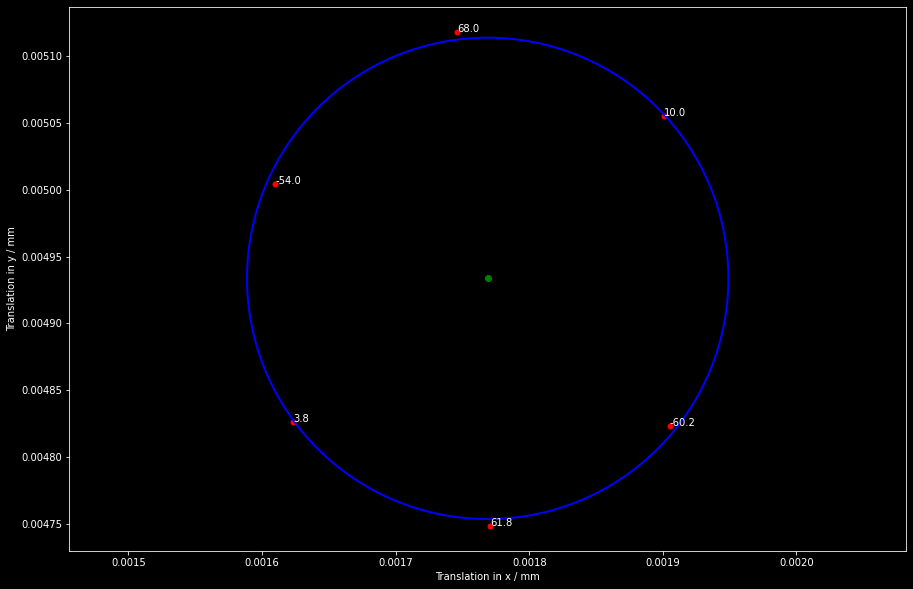

In [12]:
result_lsq_test = calculate_center_lsq(x_scaled,y_scaled)

plt.style.use('dark_background')
fig, ax = plt.subplots()
fig.set_size_inches(15,10)

ax.plot(x_scaled,y_scaled,'ro',linewidth=2, markersize=5)
for i, txt in enumerate(rot_center):
    ax.annotate(str(round(txt,1)), (x_scaled[i],y_scaled[i]))

ellipse = arc(xy=(result_lsq_test['xc'],result_lsq_test['yc']), width=2*result_lsq_test['r'], height=2*result_lsq_test['r'],
                edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
ax.add_patch(ellipse)
ax.axis('equal')

ax.plot(result_lsq_test['xc'],result_lsq_test['yc'], 'go')
ax.set_xlabel('Translation in x / mm')
ax.set_ylabel('Translation in y / mm')

print("The estimated rotation center is at: {}, {} mm".format(result_lsq_test['xc']*1e3,result_lsq_test['yc']*1e3) )

# Fit an ellipse with least squares (maybe as robust error correction?)

Fitted parameters:
a, b, c, d, e, f = [ 7.56050520e-01 -3.18206623e-02  6.53739288e-01 -2.51598996e-03
 -6.39434704e-03  1.79747835e-05]
x0, y0, ap, bp, e, phi =  0.001767726372639481 0.004933616031391817 0.00018641547008605393 0.00017274733889415257 0.37585324027806016 1.4200291281278328


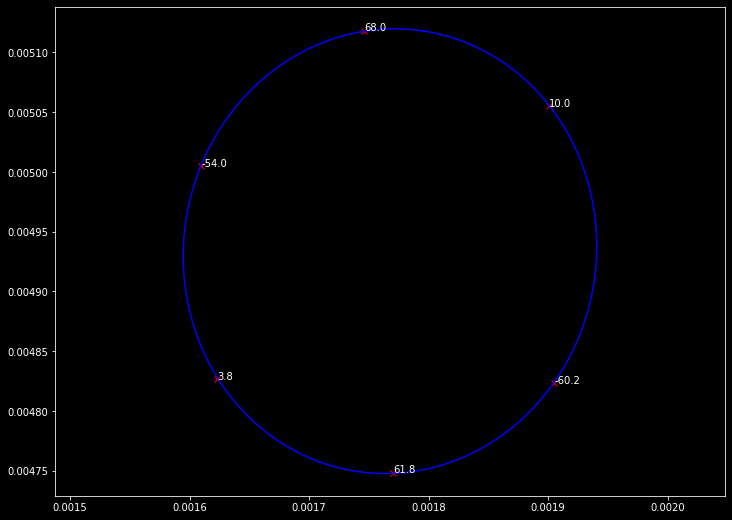

In [13]:
coeffs = fit_ellipse(np.array(x_scaled), np.array(y_scaled))
print('Fitted parameters:')
print('a, b, c, d, e, f =', coeffs)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)


plt.gcf().set_size_inches(12,9)
plt.plot(x_scaled, y_scaled, 'rx')     # given points
for i, txt in enumerate(rot_center):
    plt.gca().annotate(str(round(txt,1)), (x_scaled[i], y_scaled[i]))
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
plt.plot(x, y,'b')
plt.gca().axis('equal')
plt.show()